
Training model with adam optimizer


c:\Users\dinkelmann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1049
           1       0.59      0.55      0.57       360

    accuracy                           0.79      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.79      0.78      1409



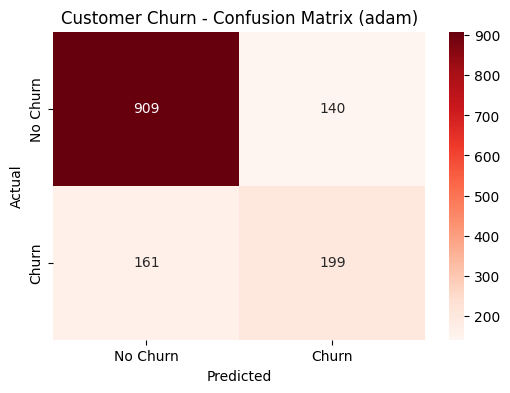

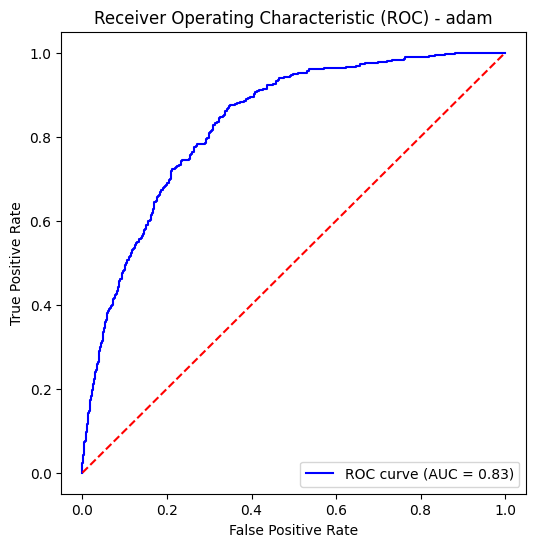


Training model with rmsprop optimizer


c:\Users\dinkelmann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1049
           1       0.58      0.56      0.57       360

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



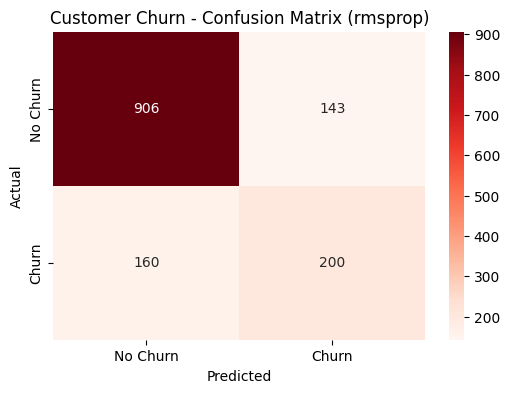

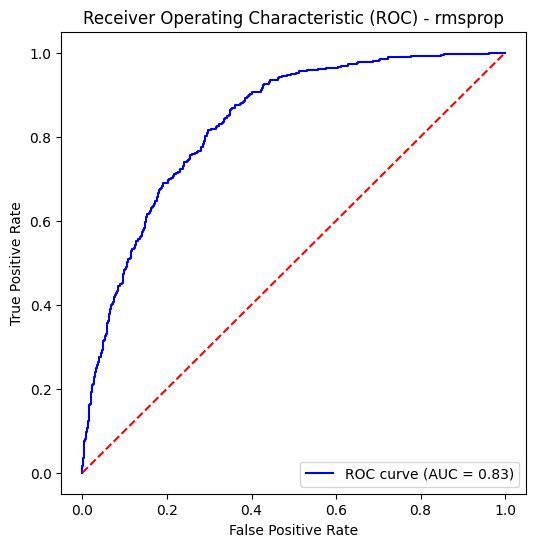


Training model with sgd optimizer


c:\Users\dinkelmann\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1049
           1       0.62      0.57      0.60       360

    accuracy                           0.80      1409
   macro avg       0.74      0.73      0.73      1409
weighted avg       0.80      0.80      0.80      1409



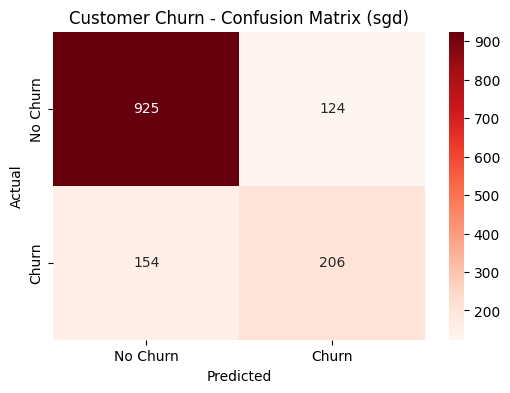

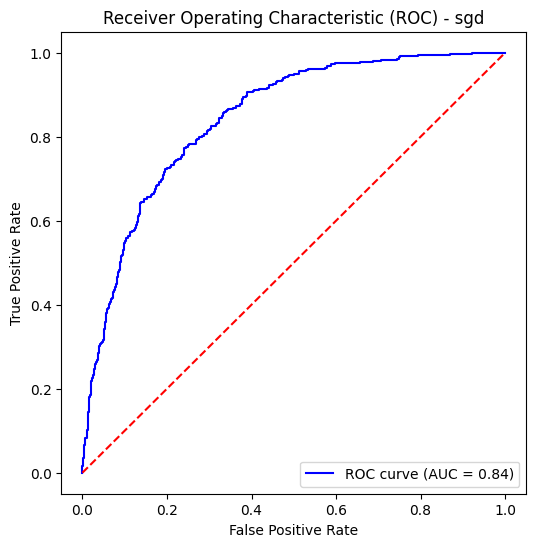

adam optimizer final validation accuracy: 0.7844, AUC: 0.8341
rmsprop optimizer final validation accuracy: 0.7817, AUC: 0.8337
sgd optimizer final validation accuracy: 0.7977, AUC: 0.8438


In [ ]:
#Link to github code:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

#Step 1: Importing the dataset
df = pd.read_csv("teleconnect.csv")
df.head()

#Step 2: Processing the data
#customer ID will not be used in the analysis and can therefore be dropped from the DF
df = df.drop("customerID", axis=1)

#check for missing values (NaN) in the dataset 
#print(df.isnull().sum())
#Since all columns have output values of 0 for the sum of the missing values, no action is needed.
#Check for blank spaces (" ")
#print((df == " ").sum())
#TotalCharges has 11 blank spaces and filling the (NaN) with the median of TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

#Set binary classification based on customer churn for either 0 or 1
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

#Scaling all the numerical values in the dataset
# Scale numerical features
n_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[n_cols] = scaler.fit_transform(df[n_cols])
df.head()

#Using a labelencoder for to categorize the text data types 
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)

#Splitting the data into a test and training set
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

#Step 3: Building the basic ANN model
def create_model(optimizer='adam'):
    model = Sequential([
        Dense(32, activation='relu', input_dim=X_train.shape[1]),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Step 4: Evaluating the baseline ANN model with different optimizers
optimizers = ['adam', 'rmsprop', 'sgd']
results = {}

for opt in optimizers:
    print(f"\nTraining model with {opt} optimizer")
    model = create_model(optimizer=opt)
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
    
    #Prediction of the test set
    y_pred_prob = model.predict(X_test).ravel()  # probabilities for ROC
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    #Classification report
    print(classification_report(y_test, y_pred))
    
    #Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['No Churn','Churn'], yticklabels=['No Churn','Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Customer Churn - Confusion Matrix ({opt})')
    plt.show()
    
    #ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {opt}')
    plt.legend(loc='lower right')
    plt.show()
    
    #Store results
    results[opt] = {
        "history": history,
        "classification_report": classification_report(y_test, y_pred),
        "confusion_matrix": cm,
        "roc_auc": roc_auc
    }

#Step 5: Compare optimizer performance
for opt in optimizers:
    print(f"{opt} optimizer final validation accuracy: {results[opt]['history'].history['val_accuracy'][-1]:.4f}, AUC: {results[opt]['roc_auc']:.4f}")
